# Capstone Project: Police Call Outcome Prediction

This notebook explores and analyzes police call data with the goal of predicting outcomes like arrests or citations. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [198]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the years (2013-2024) from CSV files. The data is then concatenated into a single DataFrame for analysis.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [200]:
# Use all the years available, including up to recently
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 3586857


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [202]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
2600626,20210424110850PD,8583726,5/15/2021 12:00:00 AM,P211140236,2,4/24/2021 12:00:00 AM,4/24/2021 12:00:00 AM,07:35:51,1055,CORONERS CASE,R,Report taken,[2100]-[2200] ALMADEN RD,San Jose,CA,37.295052,-121.879996,Canoas Garden and Almaden
288712,20131130070932PS,5104832,5/13/2021 12:00:00 AM,P133340131,6,11/30/2013 12:00:00 AM,11/30/2013 12:00:00 AM,03:51:44,11550,USE OF CONTROLLED SUBSTANCE,A,Arrest Made,E CAPITOL EX & STORY RD,San Jose,CA,37.325810,-121.865771,Little Saigon and Spring Brook
1644691,20180331183403PD,7117051,5/14/2021 12:00:00 AM,P180900787,4,3/31/2018 12:00:00 AM,3/31/2018 12:00:00 AM,18:20:55,22500,PARKING VIOLATION,CAN,Canceled,[200]-[300] SUNOL ST,San Jose,CA,37.325247,-121.905922,O'Connor Park
3123082,20230123020204PS,9410265,1/23/2023 12:00:00 AM,P230230076,6,1/23/2023 12:00:00 AM,1/23/2023 12:00:00 AM,01:58:14,1195,VEHICLE STOP,N,No report required; dispatch record only,E SAN ANTONIO ST & S 33RD ST,San Jose,CA,37.351348,-121.851783,Mayfair
488498,20140720210911PD,5395403,5/13/2021 12:00:00 AM,P142010661,2,7/20/2014 12:00:00 AM,7/20/2014 12:00:00 AM,17:40:10,1179,"VEHICLE ACCIDENT, AMB DISPATCH",R,Report taken,WILL ROGERS DR & RANCHERO WY,San Jose,CA,37.306864,-121.973763,Starbird


In [203]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3586857 entries, 0 to 3586856
Data columns (total 18 columns):
 #   Column            Dtype  
---  ------            -----  
 0   CDTS              object 
 1   EID               int64  
 2   START_DATE        object 
 3   CALL_NUMBER       object 
 4   PRIORITY          int64  
 5   REPORT_DATE       object 
 6   OFFENSE_DATE      object 
 7   OFFENSE_TIME      object 
 8   CALLTYPE_CODE     object 
 9   CALL_TYPE         object 
 10  FINAL_DISPO_CODE  object 
 11  FINAL_DISPO       object 
 12  ADDRESS           object 
 13  CITY              object 
 14  STATE             object 
 15  LATITUDE          float64
 16  LONGITUDE         float64
 17  neighborhood      object 
dtypes: float64(2), int64(2), object(14)
memory usage: 492.6+ MB


In [204]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.586857e+06,3.586857e+06,3.217154e+06,3.217154e+06
mean,7.367982e+06,3.250629e+00,3.732100e+01,-1.218711e+02
std,1.576600e+06,1.369408e+00,4.303979e-02,4.786456e-02
min,4.684476e+06,0.000000e+00,3.400982e+01,-1.220357e+02
25%,5.997906e+06,2.000000e+00,3.729686e+01,-1.219022e+02
50%,7.339761e+06,3.000000e+00,3.732443e+01,-1.218690e+02
75%,8.721333e+06,4.000000e+00,3.734905e+01,-1.218384e+02
max,1.016501e+07,8.000000e+00,3.753923e+01,-1.179017e+02


In [205]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,3586857,3586857,3586857,3586857,3586857,3586857,3586857,3586249,3586857,3586857,3472489,3586857,3586857,3200962
unique,3560324,1124,3492585,4264,4264,92069,232,248,25,25,85195,1,1,295
top,20150129195025PS,5/14/2021 12:00:00 AM,P132070252,7/4/2015 12:00:00 AM,7/4/2015 12:00:00 AM,18:15:00,415,DISTURBANCE,N,No report required; dispatch r,Not a valid geographical locat,San Jose,CA,Spartan Keyes and Wool Creek
freq,4,1270415,10,1305,1305,88,351805,351752,1559306,1115053,12249,3586857,3586857,96800


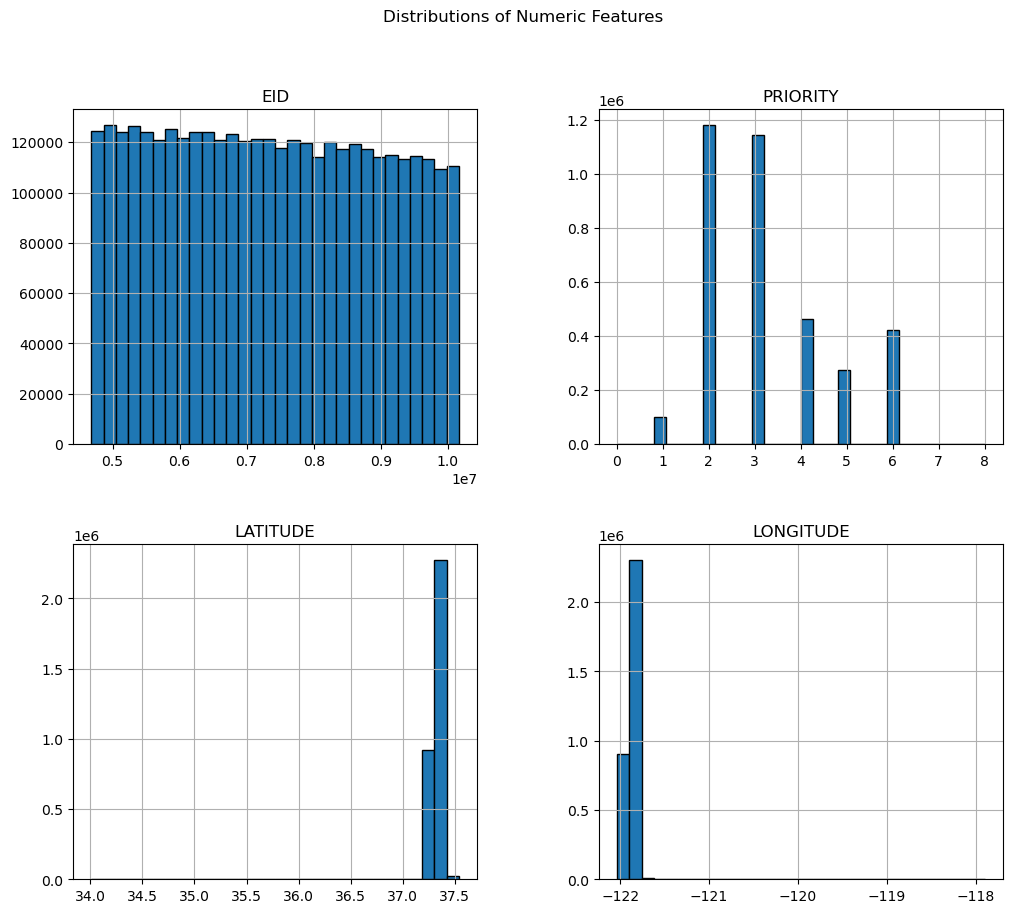

In [206]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [207]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                     0
EID                      0
START_DATE               0
CALL_NUMBER              0
PRIORITY                 0
REPORT_DATE              0
OFFENSE_DATE             0
OFFENSE_TIME             0
CALLTYPE_CODE            0
CALL_TYPE              608
FINAL_DISPO_CODE         0
FINAL_DISPO              0
ADDRESS             114368
CITY                     0
STATE                    0
LATITUDE            369703
LONGITUDE           369703
neighborhood        385895
dtype: int64

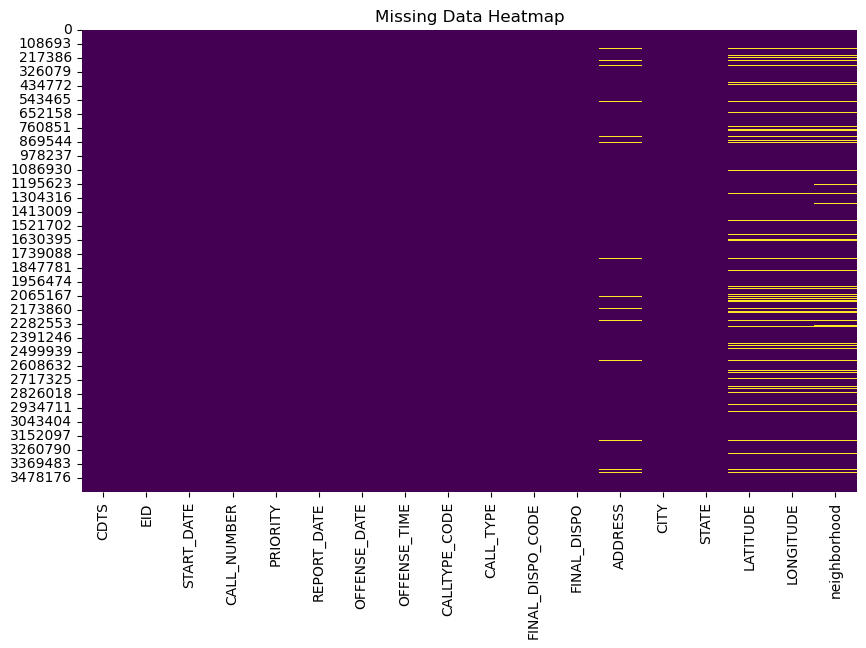

In [216]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [217]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 3560324 unique values
START_DATE: 1124 unique values
CALL_NUMBER: 3492585 unique values
REPORT_DATE: 4264 unique values
OFFENSE_DATE: 4264 unique values
OFFENSE_TIME: 92069 unique values
CALLTYPE_CODE: 232 unique values
CALL_TYPE: 248 unique values
FINAL_DISPO_CODE: 25 unique values
FINAL_DISPO: 25 unique values
ADDRESS: 85195 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [218]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      96800
Little Saigon and Spring Brook    60327
Five Wounds-San Jose High         52208
Trimble Business Area             52204
Fruitdale and Sherman Oaks        48479
                                  ...  
Villages                            636
Linda Vista and Hillcrest           425
Meadowlands                         420
Alta Vista                          362
Santa Teresa Hills                  312
Name: count, Length: 295, dtype: int64

In [219]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          1559306
CAN         604855
R           411013
G           208504
NR          129431
E            87956
D            73575
A            72429
DUPNCAN      66338
GD           64382
O            57016
H            48760
ADV          44845
C            40362
T            37698
U            36510
B            30894
F            10620
M             1019
P              745
Z              423
TOT            172
DUP              2
ESNT             1
AA               1
Name: count, dtype: int64

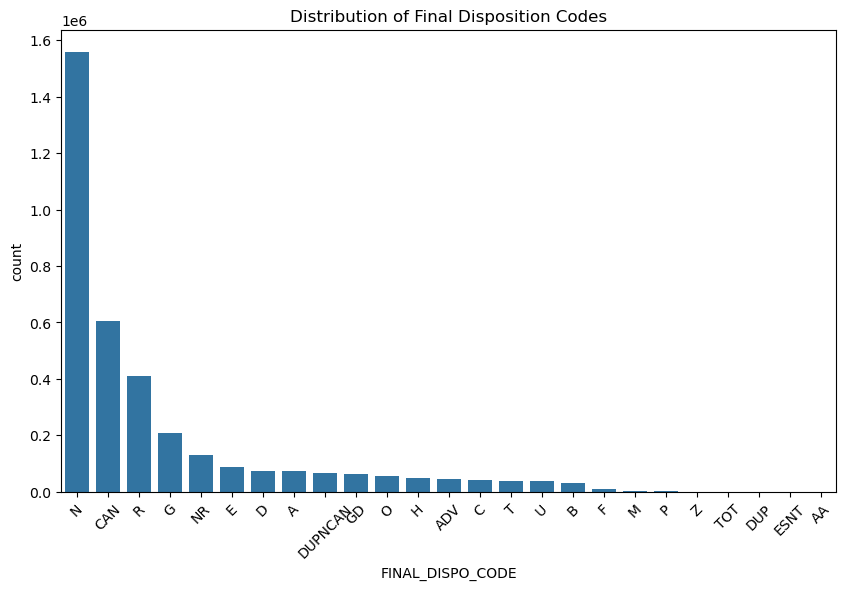

In [220]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [221]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r                      1115053
Canceled                                             604855
No report required; dispatch record only             444253
Report taken                                         411013
No Disposition                                       176164
Gone on Arrival/unable to loca                       160776
No Response                                          129431
Arrest Made                                           72429
Traffic Citation Issued, Non-H                        70693
Supplemental report taken                             57016
Gone on Arrival/unable to locate                      47728
Traffic Citation Issued, Hazar                        46767
Criminal Citation                                     40362
Courtesy Service/Citizen or ag                        37887
Turned over To (TOT)                                  37698
Unfounded event                                       36510
Arrest by Warrant           

In [222]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'NR': 'No Response',
 'G': 'Gone on Arrival/unable to locate',
 'CAN': 'Canceled',
 'N': 'No report required; dispatch record only',
 'DUPNCAN': 'No Disposition',
 'R': 'Report taken',
 'GD': 'No Disposition',
 'O': 'Supplemental report taken',
 'H': 'Courtesy Service/Citizen or agency assist',
 'A': 'Arrest Made',
 'T': 'Turned over To (TOT)',
 'U': 'Unfounded event',
 'B': 'Arrest by Warrant',
 'F': 'Field Interview (F.I.) Completed',
 'ADV': 'No Disposition',
 'E': 'Traffic Citation Issued, Non-Hazardous Violation',
 'P': 'Prior case, follow-up activity only',
 'C': 'Criminal Citation',
 'D': 'Traffic Citation Issued, Hazardous Violation',
 'M': 'Stranded motorist assist',
 'ESNT': 'No Disposition',
 'DUP': 'No Disposition',
 'Z': 'No Disposition',
 'TOT': 'No Disposition',
 'AA': 'No Disposition'}

In [223]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'415FC': 'DISTURBANCE, FIRECRACKERS',
 '1062': 'MEET THE CITIZEN',
 '1057': 'FIREARMS DISCHARGED',
 '415F': 'DISTURBANCE, FAMILY',
 '647F': 'DRUNK IN PUBLIC',
 '1033A': 'ALARM, AUDIBLE',
 '5150': 'MENTALLY DISTURBED PERSON',
 '1065X': 'MISSING FEMALE',
 '1033S': 'ALARM, SILENT',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '23103': 'RECKLESS DRIVING',
 '415M': 'DISTURBANCE, MUSIC',
 '1033': 'ALARM',
 '911CELL': 'UNK TYPE 911 CALL FROM CELL',
 '23152': 'MISDEMEANOR DUI',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '415A': 'DISTURBANCE, FIGHT',
 '10851': 'STOLEN VEHICLE',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAMAGE',
 '415': 'DISTURBANCE',
 '1154': 'SUSPICIOUS VEHICLE',
 '1066': 'SUSPICIOUS PERSON',
 '1067X': 'FEMALE CALLING FOR HELP',
 '1070': 'PROWLER',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '242': 'BATTERY',
 '22500': 'PARKING VIOLATION',
 '1195': 'VEHICLE STOP',
 '1095': 'PEDESTRIAN STOP',
 '1125': 'TRAFFIC HAZARD',
 '1179': 'VEHICLE ACCIDENT, AMB DISPATCHED',
 '537': 'DEFRAUDING AN INKEEPER',
 '

## Focus on Target Dispositions

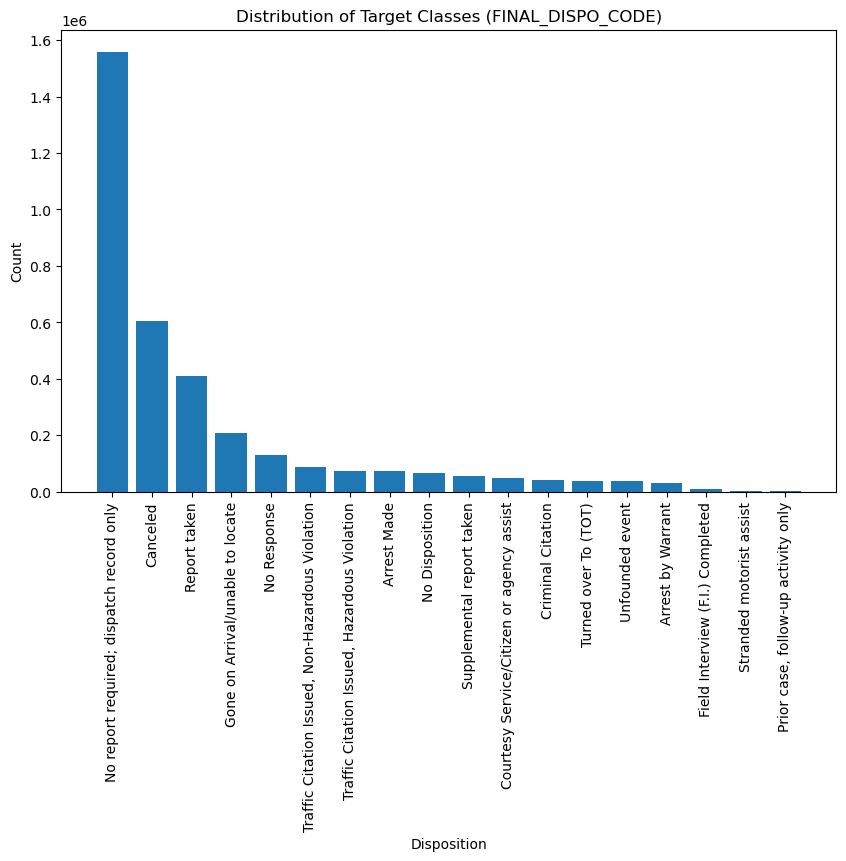

In [225]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [228]:
model_utils.transform_offense_date(all_police_df)

In [229]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    3443172
A          72429
C          40362
B          30894
Name: count, dtype: int64

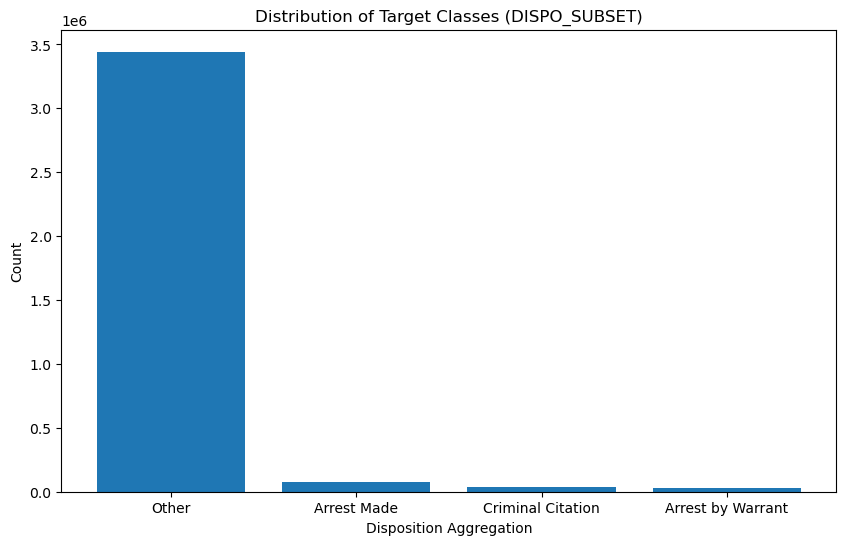

In [231]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

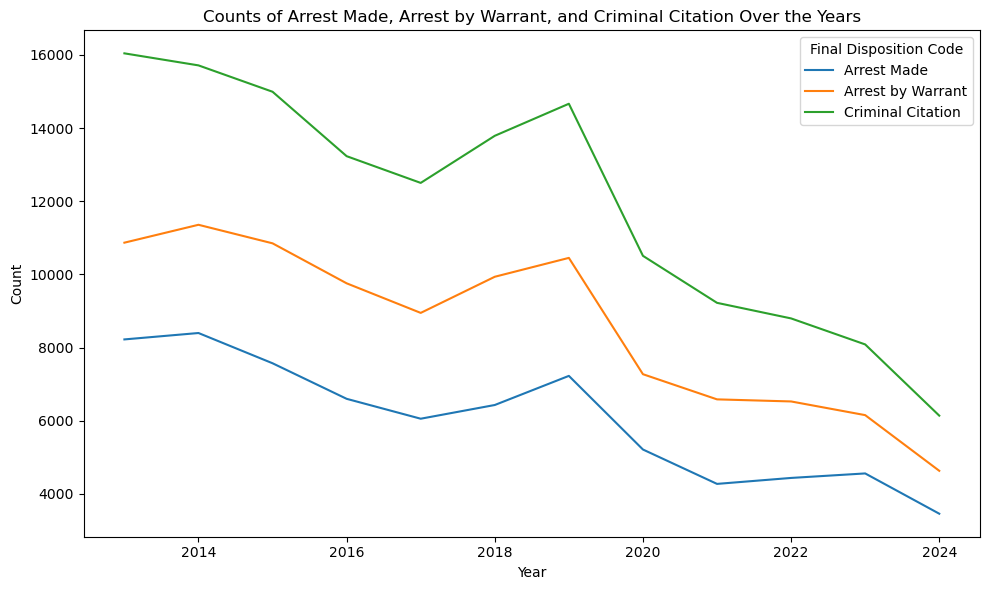

In [232]:
# Filter the dataframe to include only the relevant disposition codes
filtered_df = all_police_df[all_police_df['FINAL_DISPO_CODE'].isin(['A', 'B', 'C'])]

# Group by year and final disposition code and count occurrences
dispo_counts = filtered_df.groupby(['OFFENSE_YEAR', 'FINAL_DISPO_CODE']).size().unstack(fill_value=0)

# Rename columns to use the disposition names instead of codes
dispo_counts.rename(columns=dispo_mapping, inplace=True)

# Plot the graph
dispo_counts.plot(kind='line', stacked=True, figsize=(10, 6))

# Add title and labels
plt.title('Counts of Arrest Made, Arrest by Warrant, and Criminal Citation Over the Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Final Disposition Code')

# Show the plot
plt.tight_layout()
plt.savefig('images/final_disps_over_years.png')
plt.show()


## Data Cleaning and Feature Engineering

In [234]:
police_calls_encoded, encoder = model_utils.clean_and_transform_data(all_police_df)

Police Calls Dataset: 3586857 rows before cleaning, 3200436 rows after cleaning.


In [235]:
police_calls_encoded.shape

(3200436, 535)

In [236]:
# Save the encoder to a file to be used for other models
joblib.dump(encoder, 'one_hot_encoder.pkl')

['one_hot_encoder.pkl']

## Define X and Y

In [253]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled = \
    model_utils.split_data(police_calls_encoded, dispo_mapping)

classes = ['A' 'B' 'C' 'Other']
(2560348, 534)
(640088, 534)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 2456798, 0: 52595, 2: 28682, 1: 22273})
Counter({3: 103550, 0: 52595, 2: 28682, 1: 22273})


y_train distribution: Counter({3: 2456798, 0: 52595, 2: 28682, 1: 22273})
y_test distribution: Counter({3: 614201, 0: 13149, 2: 7170, 1: 5568})
y_train_resampled distribution: Counter({3: 2456798, 0: 52595, 2: 28682, 1: 22273})


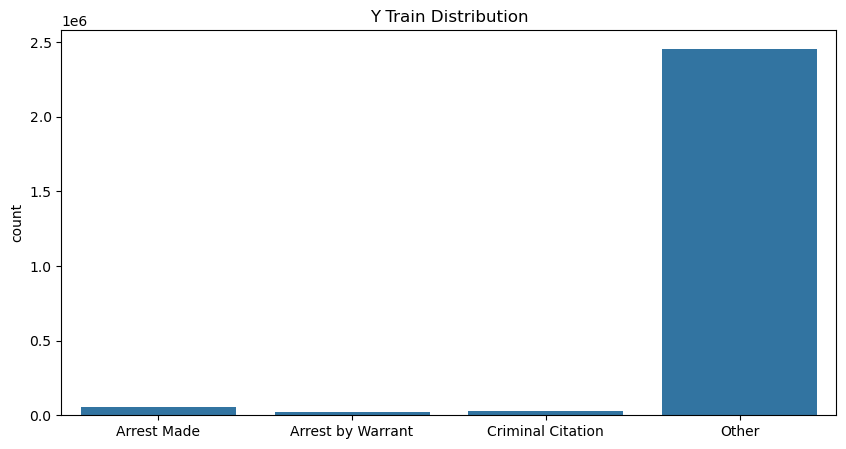

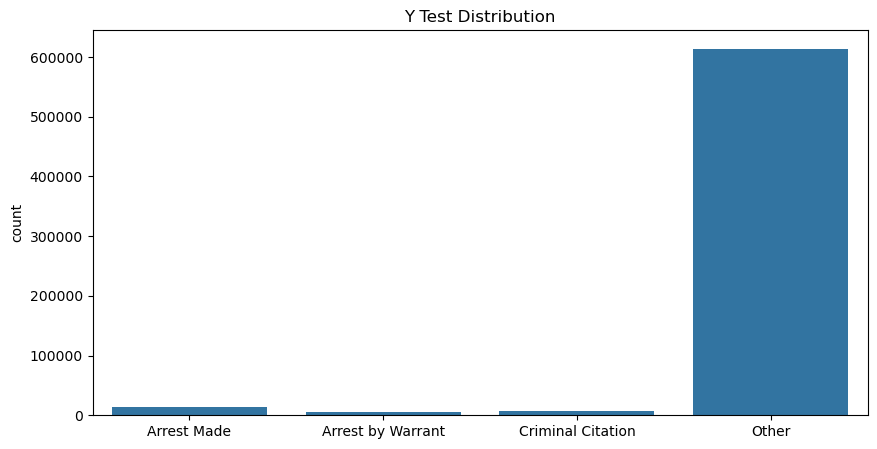

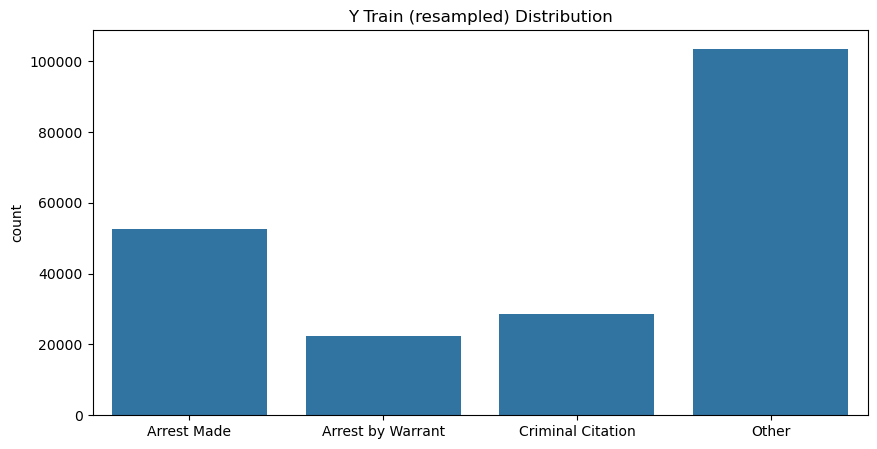

In [256]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [91]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [93]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [95]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00     13149
Arrest by Warrant       0.00      0.00      0.00      5568
Criminal Citation       0.00      0.00      0.00      7170
            Other       0.96      1.00      0.98    614201

         accuracy                           0.96    640088
        macro avg       0.24      0.25      0.24    640088
     weighted avg       0.92      0.96      0.94    640088



### Logistic Regression

In [98]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [99]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [100]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.18      0.67      0.29     13149
Arrest by Warrant       0.58      0.62      0.60      5568
Criminal Citation       0.14      0.50      0.21      7170
            Other       0.99      0.90      0.94    614201

         accuracy                           0.89    640088
        macro avg       0.47      0.67      0.51    640088
     weighted avg       0.96      0.89      0.92    640088



#### Hyperparameter Tuning

In [102]:
grid_search_scoring_method = 'f1_macro'

In [103]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

# Initialize Grid Search
# make sure n_jobs is reasonable so my machine doesn't run out of memory
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                              cv=5, n_jobs=3, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=3, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [104]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 10}
Best Score (f1_macro): 0.5692


In [105]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, "models/all_yr_best_logistic_regression.pkl") 

['models/all_yr_best_logistic_regression.pkl']

In [106]:
# load
best_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")

In [107]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.60      0.33      0.43     13149
Arrest by Warrant       0.72      0.62      0.66      5568
Criminal Citation       0.57      0.13      0.21      7170
            Other       0.98      0.99      0.98    614201

         accuracy                           0.97    640088
        macro avg       0.72      0.52      0.57    640088
     weighted avg       0.96      0.97      0.96    640088



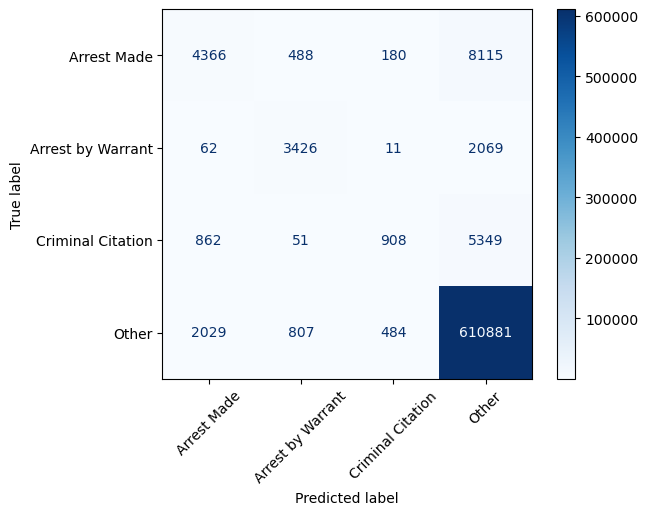

In [108]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [110]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [111]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [112]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping[code]
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                       Feature  Importance  \
205                           CALLTYPE_CODE_6M    0.005843   
189                         CALLTYPE_CODE_601T    0.003260   
204                           CALLTYPE_CODE_6F    0.003153   
69                         CALLTYPE_CODE_11377    0.002156   
112                        CALLTYPE_CODE_23152    0.002078   
64                         CALLTYPE_CODE_11300    0.001802   
170                          CALLTYPE_CODE_484    0.001607   
72                         CALLTYPE_CODE_11550    0.001010   
201                         CALLTYPE_CODE_647F    0.000932   
85                         CALLTYPE_CODE_12020    0.000880   
89                         CALLTYPE_CODE_14601    0.000818   
91                           CALLTYPE_CODE_148    0.000760   
49                        CALLTYPE_CODE_10851R    0.000659   
119                          CALLTYPE_CODE_242    0.000633   
13                         CALLTYPE_CODE_1033A    0.000604   
66      

In [113]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                     Display Name  Coefficient
49            Call Type: RECOVERED STOLEN VEHICLE     0.337797
13                      Call Type: ALARM, AUDIBLE    -0.321319
107                  Call Type: PARKING VIOLATION    -0.306809
112                    Call Type: MISDEMEANOR DUI     0.258911
189                      Call Type: TRUANT (TABS)     0.228335
153                 Call Type: DISTURBANCE, MUSIC    -0.221027
47                      Call Type: STOLEN VEHICLE     0.215471
146                Call Type: DISTURBANCE, FAMILY     0.185152
180          Call Type: MENTALLY DISTURBED PERSON     0.183085
231      Call Type: VIOLATION OF PROTECTIVE ORDER     0.177388
212                  Call Type: UNK TYPE 911 CALL    -0.153600
165                     Call Type: BURGLARY (460)     0.150866
63                      Call Type: TRAFFIC HAZARD    -0.139474
201                    Call Type: DRUNK IN PUBLIC     0.133951
125         Call Type: ASSAULT WIT

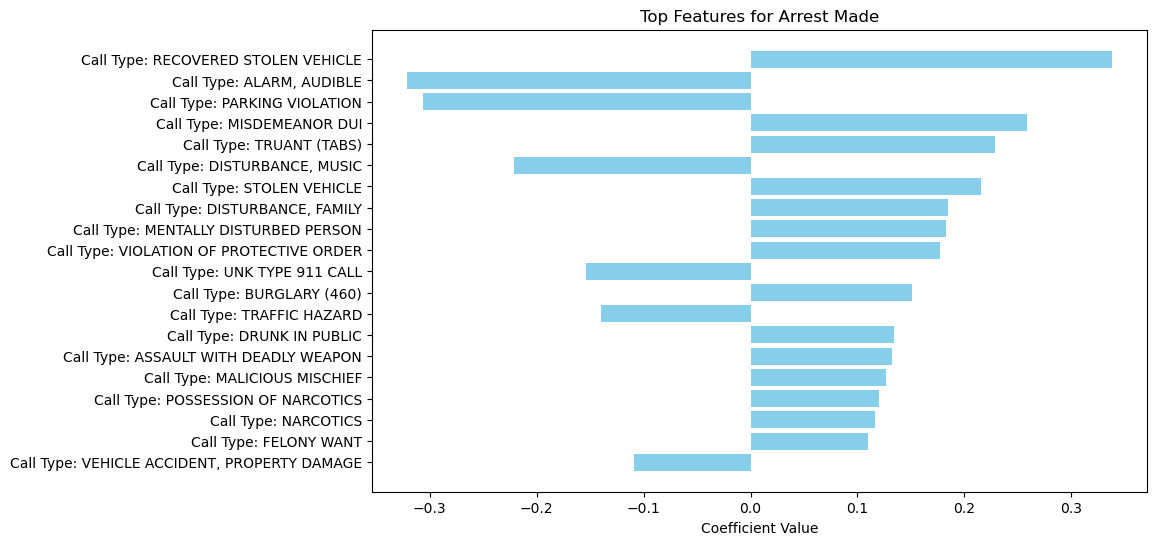

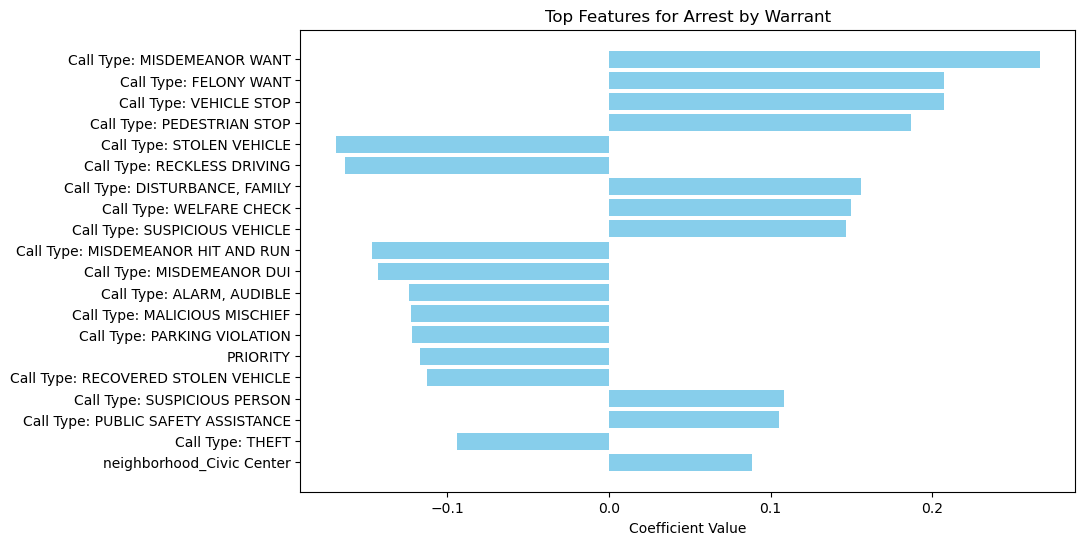

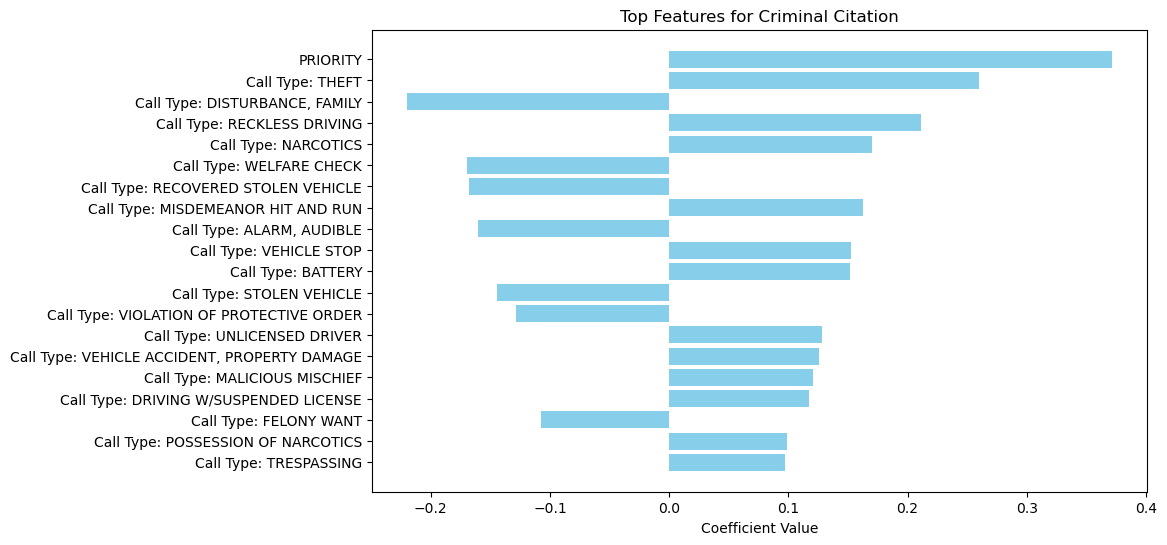

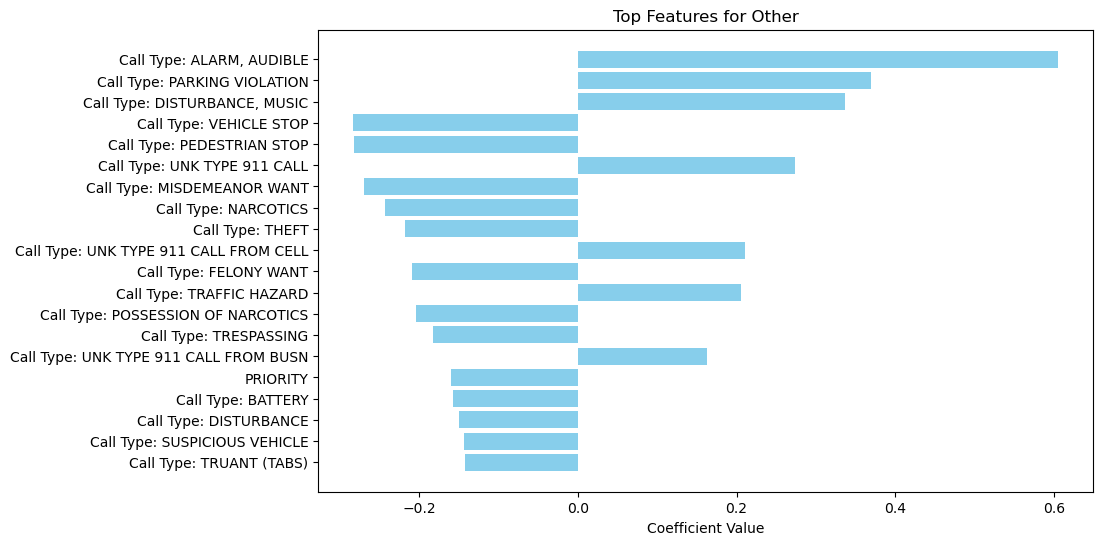

In [114]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [116]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [100]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.59      0.37      0.45     13149
Arrest by Warrant       0.67      0.57      0.62      5568
Criminal Citation       0.46      0.27      0.34      7170
            Other       0.98      0.99      0.98    614201

         accuracy                           0.97    640088
        macro avg       0.67      0.55      0.60    640088
     weighted avg       0.96      0.97      0.96    640088



#### Hyperparameter Tuning and Cross Validation

In [122]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=3,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

ERROR! Session/line number was not unique in database. History logging moved to new session 140
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 50}
Best Score (f1_macro): 0.60


In [124]:
best_rf = grid_rf.best_estimator_

In [130]:
# save
joblib.dump(best_rf, "models/all_yr_best_random_forest.pkl") 

['models/all_yr_best_random_forest.pkl']

In [187]:
best_rf = joblib.load("models/all_yr_best_random_forest.pkl")

In [188]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.59      0.37      0.45     13149
Arrest by Warrant       0.67      0.57      0.62      5568
Criminal Citation       0.45      0.27      0.34      7170
            Other       0.98      0.99      0.98    614201

         accuracy                           0.97    640088
        macro avg       0.67      0.55      0.60    640088
     weighted avg       0.96      0.97      0.96    640088



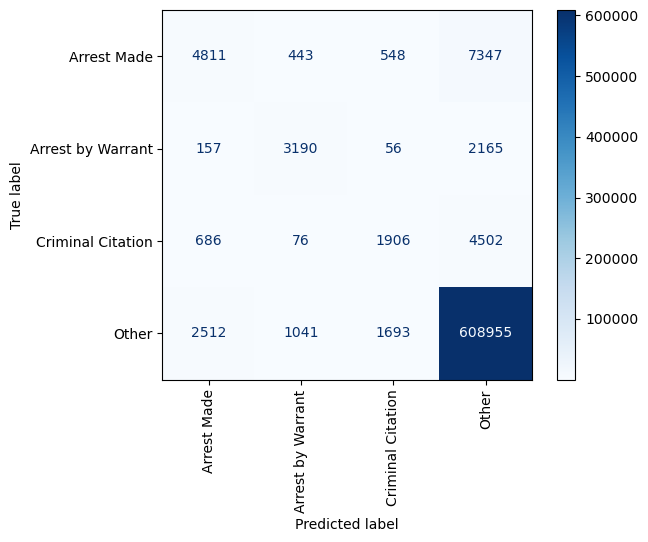

In [127]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

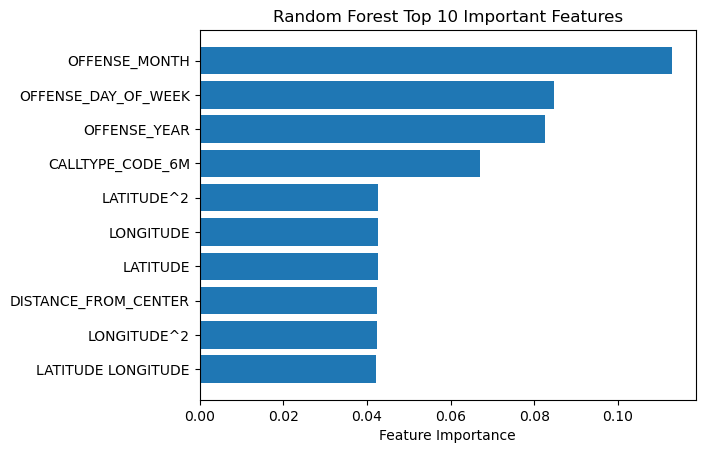

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Top 10 Important Features')
plt.show()

### Multilayer Perceptron Model

In [59]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [61]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=5,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [63]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [65]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 116s 4ms/step - accuracy: 0.9648 - loss: 0.1384 - val_accuracy: 0.9686 - val_loss: 0.1210
Epoch 2/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 125s 4ms/step - accuracy: 0.9672 - loss: 0.1234 - val_accuracy: 0.9686 - val_loss: 0.1201
Epoch 3/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 127s 4ms/step - accuracy: 0.9674 - loss: 0.1232 - val_accuracy: 0.9688 - val_loss: 0.1192
Epoch 4/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 117s 4ms/step - accuracy: 0.9672 - loss: 0.1240 - val_accuracy: 0.9680 - val_loss: 0.1194
Epoch 5/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 125s 4ms/step - accuracy: 0.9673 - loss: 0.1233 - val_accuracy: 0.9689 - val_loss: 0.1189
Epoch 6/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 123s 4ms/step - accuracy: 0.9676 - loss: 0.1229 - val_accuracy: 0.9688 - val_loss: 0.1180
Epoch 7/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 114s 4ms/step - accuracy: 0.9677 - loss: 0.1226 - val_accuracy: 0.9688 - val_loss: 0.1183
Epoch 8/20
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 114s 4ms/step - ac

In [67]:
# save
joblib.dump(mlp_model, "models/all_yr_mlp_model.pkl") 

['models/all_yr_mlp_model.pkl']

In [138]:
mlp_model = joblib.load("models/all_yr_mlp_model.pkl")

In [140]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

20003/20003 ━━━━━━━━━━━━━━━━━━━━ 12s 591us/step - accuracy: 0.9681 - loss: 0.1203
Test Accuracy: 0.9685


In [141]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

20003/20003 ━━━━━━━━━━━━━━━━━━━━ 12s 611us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.68      0.31      0.43     13149
Arrest by Warrant       0.72      0.61      0.66      5568
Criminal Citation       0.53      0.18      0.27      7170
            Other       0.97      0.99      0.98    614201

         accuracy                           0.97    640088
        macro avg       0.73      0.53      0.59    640088
     weighted avg       0.96      0.97      0.96    640088



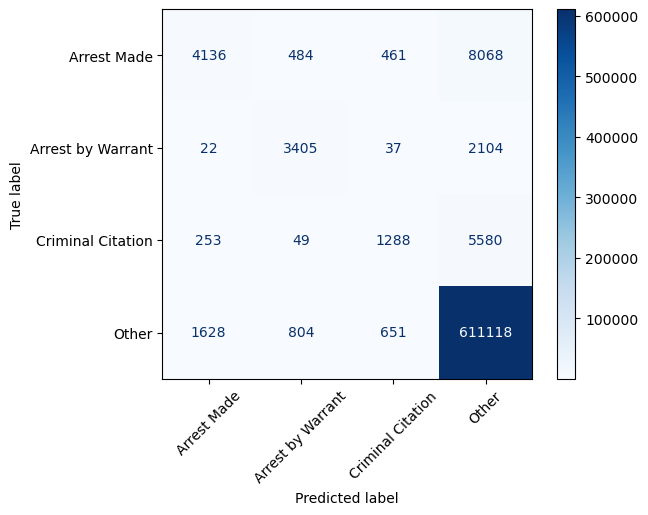

In [142]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [80]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Run a single trial to estimate time per trial
start_time = time.time()
study.optimize(objective, n_trials=1, n_jobs=1, catch=(Exception,))
end_time = time.time()
time_per_trial = end_time - start_time

# Estimate total runtime
estimated_total_time = time_per_trial * n_trials
print(f"Estimated total runtime: {estimated_total_time:.2f} seconds ({estimated_total_time/60:.2f} minutes)")

# Ask user if they want to proceed
user_input = input("Do you want to proceed with the optimization? (y/n): ")

if user_input.lower() == 'y':
    # Reset the study to start fresh
    study = optuna.create_study(direction='maximize')
    
    # Optimize the study
    start_time = time.time()
    study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
    end_time = time.time()

    actual_runtime = end_time - start_time
    print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

    # Print the best parameters and score
    print("Best parameters found: ", study.best_params)
    print("Best F1 macro score: ", study.best_value)

    # If you want to train the final model with the best parameters:
    best_params = study.best_params
    best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
    best_model.fit(X_train, y_train)
else:
    print("Optimization cancelled.")

[I 2024-10-03 14:09:44,928] A new study created in memory with name: no-name-708a095d-a6d2-4c40-aeb5-2da67c2a77ae
[I 2024-10-03 14:11:36,207] Trial 0 finished with value: 0.6480152383615323 and parameters: {'n_estimators': 343, 'learning_rate': 0.014186525083409365, 'max_depth': 5, 'subsample': 0.6427586630165608, 'colsample_bytree': 0.7378136734846162, 'gamma': 9.633964865958511e-08, 'reg_alpha': 1.5920481901822012e-05, 'reg_lambda': 0.1031434906048097}. Best is trial 0 with value: 0.6480152383615323.


Estimated total runtime: 4451.06 seconds (74.18 minutes)


Do you want to proceed with the optimization? (y/n):  y


[I 2024-10-03 14:12:16,706] A new study created in memory with name: no-name-31801dc3-b9cc-411d-8801-3594fec8164b
[I 2024-10-03 14:13:29,256] Trial 0 finished with value: 0.6465195646235692 and parameters: {'n_estimators': 132, 'learning_rate': 0.018739241854830408, 'max_depth': 6, 'subsample': 0.9860077689036426, 'colsample_bytree': 0.7835908891050262, 'gamma': 0.2158305795678403, 'reg_alpha': 1.546665653291388e-07, 'reg_lambda': 1.832881180825127e-06}. Best is trial 0 with value: 0.6465195646235692.
[I 2024-10-03 14:15:54,986] Trial 1 finished with value: 0.6550343061005082 and parameters: {'n_estimators': 410, 'learning_rate': 0.022443602658902845, 'max_depth': 3, 'subsample': 0.601717201358275, 'colsample_bytree': 0.9382039305944814, 'gamma': 0.0007694192046930423, 'reg_alpha': 0.0001145744199131715, 'reg_lambda': 0.0009388643364009585}. Best is trial 1 with value: 0.6550343061005082.
[I 2024-10-03 14:18:57,826] Trial 2 finished with value: 0.7125523459777211 and parameters: {'n_es

Actual runtime: 4954.34 seconds (82.57 minutes)
Best parameters found:  {'n_estimators': 357, 'learning_rate': 0.3387474614018501, 'max_depth': 4, 'subsample': 0.9026912519482214, 'colsample_bytree': 0.8731858874705016, 'gamma': 8.928346099773331e-07, 'reg_alpha': 0.9447093824265118, 'reg_lambda': 0.002004703296942668}
Best F1 macro score:  0.7192441690015263


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:34:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [146]:
params_14 = {
    'n_estimators': 741, 
    'learning_rate': 0.03492850638687197, 
    'max_depth': 12, 
    'subsample': 0.6837723053393205, 
    'colsample_bytree': 0.9226134169708079, 
    'gamma': 1.5470446326221786e-05, 
    'reg_alpha': 0.0003845962022654168, 
    'reg_lambda': 0.0002871222686582427
}

In [148]:
params_23 = {
    'n_estimators': 432, 
    'learning_rate': 0.08022399691850635, 
    'max_depth': 11, 
    'subsample': 0.9287027455806857, 
    'colsample_bytree': 0.8424927875337467, 
    'gamma': 5.228216539694247e-07, 
    'reg_alpha': 0.013434905218003529, 
    'reg_lambda': 0.16442377549897036
}

In [150]:
params_31 = {
    'n_estimators': 357, 
    'learning_rate': 0.3387474614018501, 
    'max_depth': 4, 
    'subsample': 0.9026912519482214, 
    'colsample_bytree': 0.8731858874705016, 
    'gamma': 8.928346099773331e-07, 
    'reg_alpha': 0.9447093824265118, 
    'reg_lambda': 0.002004703296942668
}

In [152]:
best_params = params_31
xgb_1_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_1_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8731858874705016, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=8.928346099773331e-07, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3387474614018501, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=357, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [153]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.65      0.40      0.49     13149
Arrest by Warrant       0.72      0.61      0.66      5568
Criminal Citation       0.54      0.24      0.33      7170
            Other       0.98      0.99      0.99    614201

         accuracy                           0.97    640088
        macro avg       0.72      0.56      0.62    640088
     weighted avg       0.96      0.97      0.97    640088



In [154]:
best_params = params_23
xgb_2_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_2_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8424927875337467, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=5.228216539694247e-07, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08022399691850635, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=432, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [155]:
y_pred_best_xgb_2 = xgb_2_model.predict(X_test)

xgb_2_accuracy = accuracy_score(y_test, y_pred_best_xgb_2)
xgb_2_recall = recall_score(y_test, y_pred_best_xgb_2, average='macro')
xgb_2_prec = precision_score(y_test, y_pred_best_xgb_2, average='macro')
xgb_2_f1 = f1_score(y_test, y_pred_best_xgb_2, average='macro')

print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb_2, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.66      0.38      0.49     13149
Arrest by Warrant       0.72      0.60      0.66      5568
Criminal Citation       0.55      0.25      0.35      7170
            Other       0.98      0.99      0.99    614201

         accuracy                           0.97    640088
        macro avg       0.73      0.56      0.62    640088
     weighted avg       0.96      0.97      0.97    640088



In [156]:
best_params = params_14
xgb_3_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_3_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9226134169708079, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=1.5470446326221786e-05, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03492850638687197, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=741, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [157]:
y_pred_best_xgb_3 = xgb_3_model.predict(X_test)

xgb_3_accuracy = accuracy_score(y_test, y_pred_best_xgb_3)
xgb_3_recall = recall_score(y_test, y_pred_best_xgb_3, average='macro')
xgb_3_prec = precision_score(y_test, y_pred_best_xgb_3, average='macro')
xgb_3_f1 = f1_score(y_test, y_pred_best_xgb_3, average='macro')

print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb_3, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.66      0.38      0.48     13149
Arrest by Warrant       0.72      0.60      0.65      5568
Criminal Citation       0.55      0.26      0.36      7170
            Other       0.98      0.99      0.99    614201

         accuracy                           0.97    640088
        macro avg       0.73      0.56      0.62    640088
     weighted avg       0.96      0.97      0.97    640088



In [164]:
best_xg = xgb_1_model
joblib.dump(best_xg, "models/all_yr_xgb_model.pkl") 

['models/all_yr_xgb_model.pkl']

In [166]:
best_xg = joblib.load("models/all_yr_xgb_model.pkl")

## Ensemble

In [169]:
best_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
best_rf = joblib.load("models/all_yr_best_random_forest.pkl")
best_xg = joblib.load("models/all_yr_xgb_model.pkl")

In [170]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.5703904082082525
RF F1: 0.5973420248549858
XGB F1: 0.6173400778983904


In [73]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

#### Stacking #1

In [ ]:
# Create a stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=3)

# Fit the stacking classifier
stacking_clf.fit(X_train, y_train)

In [173]:
joblib.dump(stacking_clf, "models/all_yr_stacking_1.pkl") 

['models/all_yr_stacking_1.pkl']

In [175]:
stacking_clf = joblib.load("models/all_yr_stacking_1.pkl")

In [177]:
y_pred_stacking_1 = stacking_clf.predict(X_test)
stack_1_accuracy = accuracy_score(y_test, y_pred_stacking_1)
stack_1_recall = recall_score(y_test, y_pred_stacking_1, average='macro')
stack_1_prec = precision_score(y_test, y_pred_stacking_1, average='macro')
stack_1_f1 = f1_score(y_test, y_pred_stacking_1, average='macro')
print(f"Stacking Classifier F1 Score: {stack_1_f1}")

Stacking Classifier F1 Score: 0.6179800061090149


#### Stacking #2

In [87]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=3)
stacking_clf_2.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8731858874705016,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              e...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=3)

In [179]:
joblib.dump(stacking_clf_2, "models/all_yr_stacking_2.pkl") 

['models/all_yr_stacking_2.pkl']

In [180]:
stacking_clf_2 = joblib.load("models/all_yr_stacking_2.pkl")

In [183]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.6276916439258783


## Results

In [191]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB1', 'XGB2', 'XGB3', 'Stack 1', 'Stack 2'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, xgb_2_accuracy, xgb_3_accuracy, stack_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, xgb_2_recall, xgb_3_recall, stack_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, xgb_2_prec, xgb_3_prec, stack_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, xgb_2_f1, xgb_3_f1, stack_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.959557,0.250000,0.239889,0.244840
Logistic Regression,0.967962,0.517144,0.715816,0.570390
Random Forest,0.966839,0.549022,0.672930,0.597342
MLP,0.968534,0.525174,0.726581,0.586147
XGB1,0.969643,0.560165,0.721776,0.617340
XGB2,0.969824,0.558920,0.726969,0.619012
XGB3,0.969801,0.558877,0.727288,0.619650
Stack 1,0.969640,0.556828,0.725147,0.617980
Stack 2,0.969968,0.571520,0.721708,0.627692


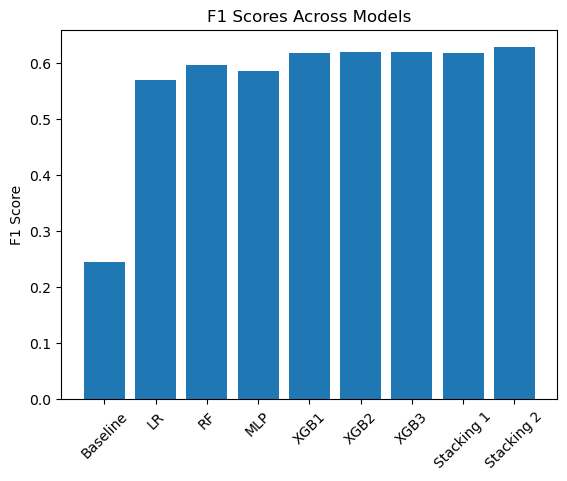

In [193]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB1', 'XGB2', 'XGB3', 'Stacking 1', 'Stacking 2']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, xgb_2_f1, xgb_3_f1, stack_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()